# MAESTRIA INTELIGENCIA  ARTIFICIAL


INTEGRANTES:
- Edwin Montenegro
- Galo Travez

## LABORATORIO 4
### INSTRUCIONES
Implementar una red neuronal convolucional (CNN) con el objetivo de entrenar un modelo de Word2Vec


---


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
import nltk
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

MPS device not found.


In [ ]:
import nltk # make sure nltk is imported
nltk.download('stopwords') # Download the stopwords resource

ss = SnowballStemmer('spanish')
sw = stopwords.words('spanish')
tokenizer = RegexpTokenizer(r'\w+')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
!head -c 1000 './workspace/mmia-6021-fall24/guides/data/gabriel_garcia_marquez_cien_annos_soledad.txt'

Gabriel García Márquez 



Cien años de soledad 



EDITADO POR "EDICIONES LA CUEVA" 



Para J omi García Ascot 
y María Luisa Elio 



Cien años de soledad 



Gabriel García Márquez 



Muchos años después, frente al pelotón de fusilamiento, el coronel Aureliano Buendía había de 
recordar aquella tarde remota en que su padre lo llevó a conocer el hielo. Macondo era entonces 
una aldea de veinte casas de barro y cañabrava construidas a la orilla de un río de aguas diáfanas 
que se precipitaban por un lecho de piedras pulidas, blancas y enormes como huevos 
prehistóricos. El mundo era tan reciente, que muchas cosas carecían de nombre, y para 
mencionarlas había que señalarías con el dedo. Todos los años, por el mes de marzo, una familia 
de gitanos desarrapados plantaba su carpa cerca de la aldea, y con un grande alboroto de pitos y 
timbales daban a conocer los nuevos inventos. Primero llevaron el imán. Un gitano corpulento, de 
barba montaraz y manos de gorri

In [ ]:
text = open('/home/emontenegrob/Labs_NLP/data/gabriel_garcia_marquez_cien_annos_soledad.txt', 'r').read().lower()
# text = open('./workspace/mmia-6021-fall24/guides/data/cap1.txt', 'r').read().lower()

In [ ]:
def split_tokens(text):
    tokens = tokenizer.tokenize(text)
    tokens = [w for w in tokens if w not in sw]
    #tokens = [ss.stem(w) for w in tokens if w not in sw]
    return tokens


In [ ]:
tokens = split_tokens(text)

In [ ]:
tokens[:25]

['gabriel',
 'garcía',
 'márquez',
 'cien',
 'años',
 'soledad',
 'editado',
 'ediciones',
 'cueva',
 'j',
 'omi',
 'garcía',
 'ascot',
 'maría',
 'luisa',
 'elio',
 'cien',
 'años',
 'soledad',
 'gabriel',
 'garcía',
 'márquez',
 'años',
 'después',
 'frente']

###  Construcción del vocabulario

In [ ]:
# Construcción del vocabulario
counts = Counter(tokens)
counts_more_than_1 = {k: v for k, v in counts.items() if v > 1}
vocab = list(counts_more_than_1.keys())
itot = dict(enumerate(vocab))
ttoi = {v: k for k, v in itot.items()}

tokens_more_than_1 = [w for w in tokens if w in vocab]


In [ ]:
counts

Counter({'gabriel': 184,
         'garcía': 173,
         'márquez': 241,
         'cien': 182,
         'años': 357,
         'soledad': 217,
         'editado': 1,
         'ediciones': 2,
         'cueva': 2,
         'j': 10,
         'omi': 1,
         'ascot': 1,
         'maría': 4,
         'luisa': 1,
         'elio': 1,
         'después': 229,
         'frente': 77,
         'pelotón': 23,
         'fusilamiento': 24,
         'coronel': 312,
         'aureliano': 794,
         'buendía': 406,
         'recordar': 22,
         'aquella': 109,
         'tarde': 149,
         'remota': 12,
         'padre': 117,
         'llevó': 63,
         'conocer': 28,
         'hielo': 29,
         'macondo': 180,
         'entonces': 272,
         'aldea': 33,
         'veinte': 32,
         'casas': 35,
         'barro': 7,
         'cañabrava': 2,
         'construidas': 2,
         'orilla': 4,
         'río': 18,
         'aguas': 8,
         'diáfanas': 2,
         'precipitaban': 

### Let's prepare the window for word2vec

In [ ]:
# Generación de pares de entrenamiento
def window(tokens, win=2):
    output = []
    for i, w in enumerate(tokens):
        target = ttoi[w]
        window = [tokens[i + j] for j in range(-win, win + 1, 1)
                  if (i + j >= 0) & (i + j < len(tokens)) & (j != 0)]
        output += [(target, ttoi[j]) for j in window]
    return output

In [ ]:
data_windowed = window(tokens_more_than_1, win=4)

In [ ]:
data_windowed

[(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (1, 0),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (2, 0),
 (2, 1),
 (2, 3),
 (2, 4),
 (2, 5),
 (2, 6),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 4),
 (3, 5),
 (3, 6),
 (3, 7),
 (4, 0),
 (4, 1),
 (4, 2),
 (4, 3),
 (4, 5),
 (4, 6),
 (4, 7),
 (4, 8),
 (5, 1),
 (5, 2),
 (5, 3),
 (5, 4),
 (5, 6),
 (5, 7),
 (5, 8),
 (5, 1),
 (6, 2),
 (6, 3),
 (6, 4),
 (6, 5),
 (6, 7),
 (6, 8),
 (6, 1),
 (6, 9),
 (7, 3),
 (7, 4),
 (7, 5),
 (7, 6),
 (7, 8),
 (7, 1),
 (7, 9),
 (7, 3),
 (8, 4),
 (8, 5),
 (8, 6),
 (8, 7),
 (8, 1),
 (8, 9),
 (8, 3),
 (8, 4),
 (1, 5),
 (1, 6),
 (1, 7),
 (1, 8),
 (1, 9),
 (1, 3),
 (1, 4),
 (1, 5),
 (9, 6),
 (9, 7),
 (9, 8),
 (9, 1),
 (9, 3),
 (9, 4),
 (9, 5),
 (9, 0),
 (3, 7),
 (3, 8),
 (3, 1),
 (3, 9),
 (3, 4),
 (3, 5),
 (3, 0),
 (3, 1),
 (4, 8),
 (4, 1),
 (4, 9),
 (4, 3),
 (4, 5),
 (4, 0),
 (4, 1),
 (4, 2),
 (5, 1),
 (5, 9),
 (5, 3),
 (5, 4),
 (5, 0),
 (5, 1),
 (5, 2),
 (5, 4),
 (0, 9),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 1),
 (0, 2),
 (0, 4),
 (0, 10),
 (1, 3),


In [ ]:
# Definición del Dataset
class text_dataset(Dataset):
    def __init__(self, data_windowed):
        self.data = data_windowed

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x, y = self.data[idx]
        return torch.tensor(x, dtype=torch.long), torch.tensor(y, dtype=torch.long)



In [ ]:
dataset = text_dataset(data_windowed)

### Building the network

In [ ]:
# Redefinimos el modelo Word2Vec con CNN
class Word2VecCNN(nn.Module):
    def __init__(self, vocab_size, embedding_size, kernel_size=3, num_channels=100):
        super(Word2VecCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.conv1d = nn.Conv1d(in_channels=embedding_size, out_channels=num_channels, kernel_size=kernel_size, padding=1)
        self.fc = nn.Linear(num_channels, vocab_size)

    def forward(self, input):
        embedded = self.embedding(input)  # Tamaño: (batch_size, embedding_size)
        embedded = embedded.unsqueeze(2)  # Agrega una dimensión: (batch_size, embedding_size, 1)
        conv_out = F.relu(self.conv1d(embedded))
        pooled = F.adaptive_max_pool1d(conv_out, 1).squeeze()  # Max pooling para obtener una salida de tamaño fijo
        logits = self.fc(pooled)
        return logits

In [ ]:
# Inicialización del modelo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = Word2VecCNN(len(vocab), 100).to(device)

Using device: cuda


In [ ]:
model

Word2VecCNN(
  (embedding): Embedding(7406, 100)
  (conv1d): Conv1d(100, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc): Linear(in_features=100, out_features=7406, bias=True)
)

In [ ]:
# Parámetros de entrenamiento
LR =0.0001
EPOCHS = 30
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)


In [ ]:
# DataLoader para manejo de datos
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


In [ ]:
# Entrenamiento del modelo
progress_bar = tqdm(range(EPOCHS * len(dataloader)))
running_loss = []

for epoch in range(EPOCHS):
    epoch_loss = 0
    for center, context in dataloader:
        # Mover datos a dispositivo
        context = context.to(device)
        center = center.to(device)

        optimizer.zero_grad()
        logits = model(input=context)
        loss = loss_fn(logits, center)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        progress_bar.update()
    epoch_loss /= len(dataloader)
    running_loss.append(epoch_loss)



  0%|          | 0/464910 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|█████████▉| 464886/464910 [34:59<00:00, 242.59it/s]

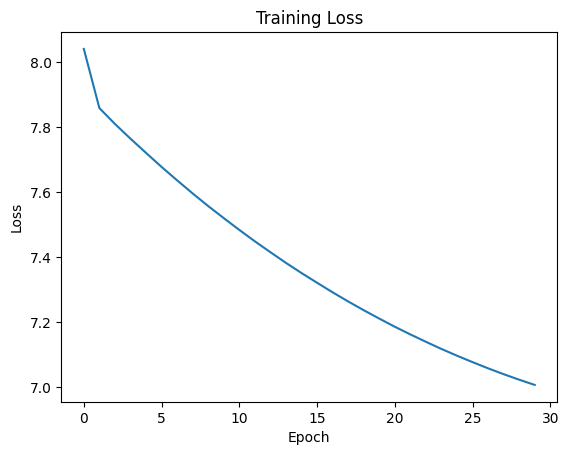

In [ ]:

# Visualización de la pérdida
plt.plot(running_loss)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()



In [ ]:
# Extraer vectores de palabras
wordvecs = model.fc.weight.cpu().detach().numpy()

In [ ]:
import numpy as np
from scipy.spatial import distance

# Extraer los vectores de palabras (pesos de la capa fully connected)
wordvecs = model.fc.weight.cpu().detach().numpy()

# Función para calcular la matriz de distancia
def get_distance_matrix(wordvecs, metric):
    dist_matrix = distance.squareform(distance.pdist(wordvecs, metric))
    return dist_matrix

# Función para obtener las k palabras más similares
def get_k_similar_words(word, dist_matrix, k=10):
    idx = ttoi[word]  # Obtiene el índice de la palabra en el vocabulario
    dists = dist_matrix[idx]  # Distancias de la palabra a todas las demás
    ind = np.argpartition(dists, k)[:k+1]  # Índices de las k+1 palabras más cercanas
    ind = ind[np.argsort(dists[ind])][1:]  # Ordenar y eliminar la palabra misma
    out = [(i, itot[i], dists[i]) for i in ind]  # Lista de palabras más similares con sus distancias
    return out

# Calcular la matriz de distancia utilizando la distancia coseno
dmat = get_distance_matrix(wordvecs, 'cosine')


In [ ]:
# Prueba de algunas palabras en el vocabulario (sin lematización)
tokens_test = ['aureliano', 'coronel', 'macondo', 'casa', 'pueblo', 'melquíades', 'arcadio', 'úrsula']

# Imprimir las 10 palabras más similares para cada palabra de prueba
for word in tokens_test:
    if word in ttoi:  # Asegurar que la palabra esté en el vocabulario entrenado
        print(word, [t[1] for t in get_k_similar_words(word, dmat, k=10)], "\n")
    else:
        print(f"La palabra '{word}' no está en el vocabulario entrenado.\n")

aureliano ['buendía', 'coronel', 'segundo', 'arcadio', 'josé', 'entonces', 'abandonara', 'recibo', 'vengo', 'informaciones'] 

coronel ['guerra', 'gerineldo', 'negó', 'pescaditos', 'hijos', 'moneada', 'fuerzas', 'noticias', 'promover', 'amigos'] 

macondo ['ciénaga', 'llevaron', 'pueblo', 'hicieron', 'negó', 'bananera', 'mar', 'empresa', 'plaza', 'mil'] 

casa ['único', 'varias', 'andaba', 'pesar', 'buscando', 'cosas', 'fernanda', 'dormir', 'dejado', 'costumbre'] 

pueblo ['acuerdo', 'familia', 'hicieron', 'pasado', 'llevaron', 'ciénaga', 'único', 'gente', 'hombres', 'mujeres'] 

melquíades ['abrió', 'haciendo', 'curiosidad', 'allí', 'punto', 'realidad', 'taller', 'pergaminos', 'polvo', 'encontraba'] 

arcadio ['josé', 'hijo', 'dio', 'atrevió', 'oficial', 'volvió', 'buendía', 'castaño', 'entonces', 'éste'] 

úrsula ['amaranta', 'demasiado', 'así', 'trató', 'cosas', 'algún', 'rebeca', 'gritó', 'regreso', 'hombre'] 



In [ ]:
# Parámetros de entrenamiento
LR =0.0001
EPOCHS = 50
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
# DataLoader para manejo de datos
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
# Entrenamiento del modelo
progress_bar = tqdm(range(EPOCHS * len(dataloader)))
running_loss = []

for epoch in range(EPOCHS):
    epoch_loss = 0
    for center, context in dataloader:
        # Mover datos a dispositivo
        context = context.to(device)
        center = center.to(device)

        optimizer.zero_grad()
        logits = model(input=context)
        loss = loss_fn(logits, center)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        progress_bar.update()
    epoch_loss /= len(dataloader)
    running_loss.append(epoch_loss)

100%|█████████▉| 774844/774850 [56:40<00:00, 233.35it/s]

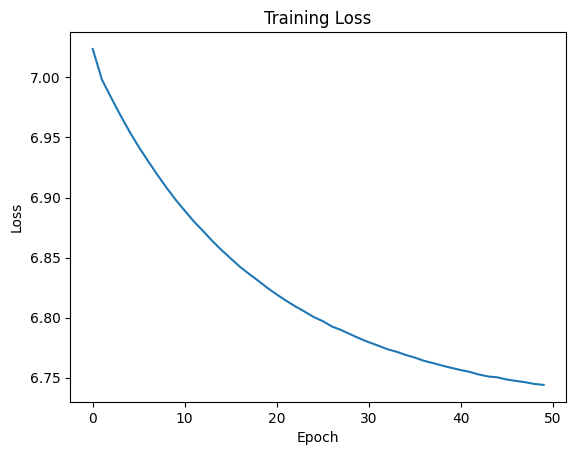

In [ ]:
# Visualización de la pérdida
plt.plot(running_loss)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


In [ ]:
# Extraer vectores de palabras
wordvecs = model.fc.weight.cpu().detach().numpy()

In [ ]:
import numpy as np
from scipy.spatial import distance

# Extraer los vectores de palabras (pesos de la capa fully connected)
wordvecs = model.fc.weight.cpu().detach().numpy()

# Función para calcular la matriz de distancia
def get_distance_matrix(wordvecs, metric):
    dist_matrix = distance.squareform(distance.pdist(wordvecs, metric))
    return dist_matrix

# Función para obtener las k palabras más similares
def get_k_similar_words(word, dist_matrix, k=10):
    idx = ttoi[word]  # Obtiene el índice de la palabra en el vocabulario
    dists = dist_matrix[idx]  # Distancias de la palabra a todas las demás
    ind = np.argpartition(dists, k)[:k+1]  # Índices de las k+1 palabras más cercanas
    ind = ind[np.argsort(dists[ind])][1:]  # Ordenar y eliminar la palabra misma
    out = [(i, itot[i], dists[i]) for i in ind]  # Lista de palabras más similares con sus distancias
    return out

# Calcular la matriz de distancia utilizando la distancia coseno
dmat = get_distance_matrix(wordvecs, 'cosine')

In [ ]:
# Prueba de algunas palabras en el vocabulario (sin lematización)
tokens_test = ['aureliano', 'coronel', 'macondo', 'casa', 'pueblo', 'melquíades', 'arcadio', 'úrsula']

# Imprimir las 10 palabras más similares para cada palabra de prueba
for word in tokens_test:
    if word in ttoi:  # Asegurar que la palabra esté en el vocabulario entrenado
        print(word, [t[1] for t in get_k_similar_words(word, dmat, k=10)], "\n")
    else:
        print(f"La palabra '{word}' no está en el vocabulario entrenado.\n")

aureliano ['segundo', 'entonces', 'buendía', 'josé', 'coronel', 'arcadio', 'hijo', 'casa', 'madre', 'dio'] 

coronel ['guerra', 'aureliano', 'gerineldo', 'buendía', 'hijos', 'entonces', 'muerte', 'negó', 'fin', 'sido'] 

macondo ['pueblo', 'mar', 'regreso', 'hicieron', 'llevaron', 'ciénaga', 'realidad', 'familia', 'hijos', 'bananera'] 

casa ['cosas', 'volvió', 'único', 'úrsula', 'fernanda', 'andaba', 'llevó', 'pesar', 'nunca', 'tarde'] 

pueblo ['hombres', 'pasado', 'macondo', 'familia', 'hicieron', 'gente', 'llevaron', 'realidad', 'único', 'mujeres'] 

melquíades ['cuarto', 'mientras', 'realidad', 'vida', 'cosas', 'punto', 'embargo', 'mundo', 'pronto', 'taller'] 

arcadio ['josé', 'buendía', 'hijo', 'dio', 'aureliano', 'entonces', 'volvió', 'segundo', 'trató', 'cosas'] 

úrsula ['amaranta', 'rebeca', 'cosas', 'casa', 'trató', 'tarde', 'dio', 'así', 'nadie', 'fernanda'] 

